In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import time
import math

In [2]:
# Формируем матрицу перестановок
def get_P(k, matrix):
    zero_warning = False
    P = np.identity(matrix.shape[0])
    prmax = abs(matrix[k, k]) 
    row = k
    for i in range(k + 1, matrix.shape[0]):
        if abs(matrix[i, k]) > prmax:
            row = i
            prmax = abs(matrix[i, k])
    P[[k, row]] = P[[row, k]]
    if prmax == 0: zero_warning = True
    return (P, row, zero_warning)


# Получаем матрицы M_i для L, U разложения
def get_Mk_P(k, matrix, flag_L):
    Mk = np.zeros((matrix.shape[0], matrix.shape[1]))
    for z in range(Mk.shape[1]):
        for i in range(Mk.shape[0]):
            if i == z:
                Mk[i, z] = 1
            elif i > z and z == k:
                matrix = get_P(k, matrix)[0] @ matrix 
                if flag_L:
                    Mk[i, z] = matrix[i, z]/matrix[z, z]
                else: 
                    Mk[i, z] = -matrix[i, z]/matrix[z, z]
            else: Mk[i, z] = 0
    return (Mk, matrix)

# Непосредственно меняем матрицу А
def computing_in_A(matrix, b):
    A = np.array(matrix)
    perest = np.identity(A.shape[0])   
    for i in range(0, matrix.shape[1]):
        per_here = get_P(i, A)[0]
        A = per_here @ A
        perest = per_here @ perest
        for j in range(i + 1, A.shape[0]):
            A[j, i] /= A[i, i]
            A[j, i + 1:] -= A[j, i] * A[i, i + 1:]
    
    b_ = perest @ b
    b_ = np.linalg.inv(np.tril(A, -1) + np.identity(A.shape[0])) @ b_
    return np.linalg.inv(np.triu(A)) @ b_


### Задача 4.1 

Найти с точностью $\varepsilon = 10^{-6}$ все корни системы нелинейных уравнений: $\newline$
$f_1(x_1, x_2) = 0$, $\newline$
$f_2(x_1, x_2) = 0$

Вариант 34:


$$f_1(x_1, x_2) = \cos(x_1) + x_2 - 1.5 = 0$$

$f_2(x_1, x_2) = 2x_1- \sin(x_2-0.5) - 1 = 0$

Локализуем корни уравнения.

Первое уравнение, разрешенное относительно $x_1$:

$g_1(x) = \arccos(1.5 - x_2)$, область определения функции: $x \in [0.5; 2.5]$

In [3]:
def g1(x):
    return np.arccos(1.5 - x) 

Второе уравнение, разрешенное относительно $x_1$:

$g_2(x) = (\sin(x_2-0.5) + 1)*0.5$

In [4]:
def g2(x):
    return (np.sin(x-0.5) + 1)*0.5

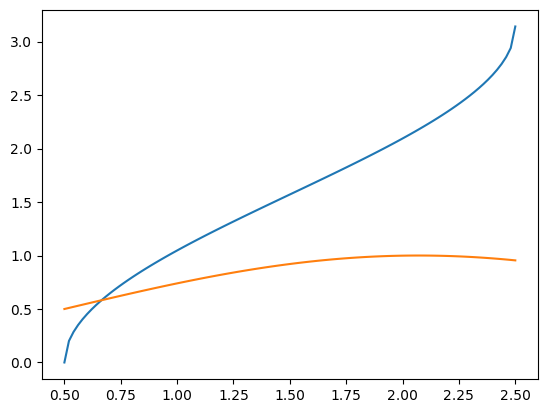

In [5]:
D = np.linspace(0.5, 2.5, 100)
g1map = np.vectorize(g1)
g2map = np.vectorize(g2)
G_1 = g1map(D)
G_2 = g2map(D)
plt.plot(D, G_1)
plt.plot(D, G_2)

Отрезок локализации: $x \in [0.6; 0.75]$

Начальное приближение: $x_1^{(0)} = 0.7, x_2^{(0)} = 0.55$

Решим систему методом Ньютона. Для это произведем линеаразацию системы. $\newline$
Тогда метод Ньютона может быть записан в форме:
$$f(x^{(n)}) + f'(x^{n})\Delta^{(n + 1)} = 0, (1)$$ где $\Delta ^{(n + 1)} = x^{(n + 1)} - x^{(n)},$ $f'(x^{n})$ - матрица Якоби

Найдем матрицу Якоби для задачи:

$$\frac {\partial f_1} {\partial x_1} = -\sin(x_1)$$
$$\frac {\partial f_1} {\partial x_2} = 1$$
$$\frac {\partial f_2} {\partial x_1} = 2$$
$$\frac {\partial f_2} {\partial x_2} = -\cos(0.5-x_2)$$

$f' = \begin {bmatrix}
    -\sin(x_1) & & 1 \\
    2 & -\cos(0.5-x_2) \\
    \end{bmatrix}$

Запишем (1) в виде $$-f(x^{(n)}) = f'(x^{n})\Delta^{(n + 1)} $$

Получили систему нелинейных уравнений, чтобы ее упростить, возьмем для решения *упрощенный метод Ньютона*. Для этого вычислим матрицу Якоби в точке начального приближения:
$A = f'(x^{(0)})$

Получили СЛАУ относительно $\Delta^{(n + 1)}$. После этого находим $x^{(n + 1)} = x^{(n)} + \Delta^{(n + 1)}$. Вычисления выполянем, пока $||\Delta^{(n + 1)}|| > \varepsilon$

$f' = \begin {bmatrix}
    -\sin(0.7) & 1  \\
    2 & -\cos(-0.5) \\
    \end{bmatrix}$

Проведем вычисления:


$A\Delta^{(n + 1)} = -f(x^{n}) = -\begin {bmatrix}
    \cos(x_1^{(n)}) + x_2^{(n)} - 1.5  \\
    2x_1^{(n)} - \sin(x_2^{(n)}-0.5) - 1 \\
    \end{bmatrix}$    

In [6]:
A = np.array([[-np.sin(0.7), 1], [2, -np.cos(-0.5)]])
x_0 = np.array([0.7, 0.55])
b_0 = np.array([-np.cos(x_0[0]) - x_0[1] + 1.5, -2*x_0[0] + np.sin(x_0[1]-0.5) + 1])
eps = 1e-6
def solve(A, b, x0, eps):
    delta_next = computing_in_A(A, b)
    print(delta_next)
    x_curr = delta_next + x0
    print(x_curr)
    b = np.array([-np.cos(x_curr[0]) - x_curr[1] + 1.5, -2*x_curr[0] + np.sin(x_curr[1]-0.5) + 1])
    while np.linalg.norm(delta_next) > eps:
        print(np.linalg.norm(delta_next))
        delta_next = computing_in_A(A, b)
        x_curr = delta_next + x_curr
        b = np.array([-np.cos(x_curr[0]) - x_curr[1] + 1.5, -2*x_curr[0] + np.sin(x_curr[1]-0.5) + 1])
    return x_curr
solve(A, b_0, x_0, eps)

[-0.13071489  0.10094897]
[0.56928511 0.65094897]
0.16515773183339513
0.01923459514695301
0.0010641058989816902
0.00013785920448856562
8.2226407406065e-06


array([0.58192615, 0.66459455])

### Задача 4.2

Дана система уравнений $Ax = b$ , где $A$ – симметричная положительно определенная матрица. Найти решение системы с помощью метода релаксации и метода, указанного в индивидуальном варианте. Сравнить оба метода решения по числу итераций и по времени решения.   

Вариант 34: $C = 8.8, m = 11$

Метод, указанный в индивидуальном варианте: метод сопряженных градиентов

1. Зададим матрицу системы при заданном значении m – размерности системы. Используя встроенную функцию для нахождения собственных чисел матриц, найти собственные числа матрицы (убедиться, что матрица $A$ > 0 ). 

Элементы матрицы A задаются формулами: $\newline$
$$a_{i, j} = \frac {\ln(i + j)^3} {t} + Ce^{-(i - j)^2}, i, j = 1..m, t = m + 0.1N,$$ $N$ - номер варианта, $m$ - размерность матрицы указанная в варианте (14), константа $C$ задана в индивидуальном варианте (7.8)

In [7]:
N = 34
m = 11
C = 8.8
def make_A(N, m, C):
    A = np.zeros((m, m))
    t = m + 0.1*N
    for i in range(m):
        for j in range(m):
            A[i, j] = np.log((i + 1 + j + 1) ** 3) / t + C * np.e **(-(i + 1 - (j + 1)) ** 2)
    return A

A = make_A(N, m, C)
print(A)
            

[[8.94440566 3.46621664 0.44998895 0.33638557 0.37328421 0.40539795
  0.43321699 0.45775512 0.47970523 0.49956152 0.51768889]
 [3.46621664 9.08881133 3.57263865 0.53446084 0.40648395 0.43321798
  0.45775512 0.47970523 0.49956152 0.51768889 0.53436445]
 [0.44998895 3.57263865 9.17328322 3.64273703 0.59439461 0.45884113
  0.47970622 0.49956152 0.51768889 0.53436445 0.54980361]
 [0.33638557 0.53446084 3.64273703 9.23321699 3.6950942  0.64088285
  0.50064752 0.51768988 0.53436445 0.54980361 0.56417713]
 [0.37328421 0.40648395 0.59439461 3.6950942  9.27970523 3.7369006
  0.67886651 0.53545046 0.5498046  0.56417713 0.57762265]
 [0.40539795 0.43321798 0.45884113 0.64088285 3.7369006  9.31768889
  3.77170353 0.71098123 0.56526313 0.57762364 0.59025278]
 [0.43321699 0.45775512 0.47970622 0.50064752 0.67886651 3.77170353
  9.34980361 3.80151621 0.73880027 0.59133879 0.60216177]
 [0.45775512 0.47970523 0.49956152 0.51768988 0.53545046 0.71098123
  3.80151621 9.37762265 3.82759186 0.76333841 0.614

Найдем собственные числа матрицы А:

In [8]:
np.linalg.eig(A)[0]

array([20.69717154, 14.38763371, 13.49689395, 11.85386381, 10.29178265,
        8.50996999,  6.91469952,  5.43555917,  2.82752084,  3.36510189,
        4.25457936])

Как видно, все собственные элементы матрицы $А$ положительны, =>, она положительно определена ($A$ > 0)

#### 2. Зададим вектор $x$ с координатами: $x_i = N$ где N ‒ номер варианта (34) и вектор $b$ как $b = Ax$.

In [9]:
x = np.full(m, 34.)
b = A @ x

3. Преобразуем систему к виду, удобному для итераций: $y = Bx + c$.

In [10]:
B = np.zeros((m, m))
c = np.full(m, 0.)
for i in range(m):
    for j in range(m):
        if (i == j):
            B[i][j] = 0
        else:
            B[i][j] = -A[i][j] / A[i][i]
    c[i] = b[i] / A[i][i]

print(B, c)

[[ 0.         -0.38752901 -0.05030954 -0.03760849 -0.04173382 -0.04532419
  -0.04843441 -0.05117781 -0.05363187 -0.05585184 -0.05787851]
 [-0.38137183  0.         -0.39308096 -0.05880426 -0.04472356 -0.04766498
  -0.05036469 -0.05277975 -0.05496445 -0.05695892 -0.05879366]
 [-0.0490543  -0.38946128  0.         -0.39710286 -0.06479628 -0.05001929
  -0.05229384 -0.05445831 -0.05643442 -0.05825226 -0.05993531]
 [-0.03643211 -0.05788458 -0.39452523  0.         -0.40019575 -0.06941057
  -0.05422244 -0.0560682  -0.05787414 -0.05954627 -0.06110299]
 [-0.04022587 -0.04380354 -0.06405318 -0.3981909   0.         -0.40269605
  -0.07315604 -0.05770124 -0.05924807 -0.06079688 -0.0622458 ]
 [-0.04350842 -0.04649415 -0.04924409 -0.06878131 -0.40105445  0.
  -0.4047896  -0.07630446 -0.06066559 -0.06199216 -0.06334755]
 [-0.04633434 -0.0489588  -0.05130656 -0.05354631 -0.07260757 -0.40339923
   0.         -0.40658781 -0.07901773 -0.06324612 -0.06440368]
 [-0.04881356 -0.05115425 -0.05327166 -0.05520481

4. Составим программу, реализующую метод релаксации с параметром $\omega$ . Изменяя значения параметра $\omega$ из интервала (0; 2) с шагом 0.1, найдём оптимальное значение параметра.

In [11]:
B3 = np.array([[0, 1/4, -1/4], [1/5, 0, 1/5], [-1/3, -1/3, 0]])
x0 = np.array([-2, -3, 3])
c0 = np.array([-2, -3, 3])
eps = 1e-5

def relax(x0, epsilon, B, c, bol, A, b):
    r0 = A @ x0 - b
    iters_arr = np.array([])
    startx_0 = copy.deepcopy(x0)
    size = B.shape[0]
    B1 = np.zeros((size, size))
    B2 = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i > j):
                B1[i][j] = B[i][j]
            elif (i < j):
                B2[i][j] = B[i][j]
    w = 1.1
    x_ans = np.zeros(B.shape[0])
    less_iters = 10000
    for i in range(1, 20):
        w_curr = i / 10
        x1 = next_approx(B, c, w_curr, startx_0)
        rn = A @ x1 - b
        iters = 1
        while True:
            x0 = x1
            x1 = next_approx(B, c, w, x0)
            iters += 1
            if (np.linalg.norm(rn) / np.linalg.norm(r0) <= epsilon) or iters > 1000: break 
            rn = A @ x1 - b

        iters_arr = np.append(iters_arr, iters)
        if (iters < less_iters):
            x_ans = x1
            less_iters = iters
            w = w_curr

    return (x_ans, np.min(iters_arr), w)


def next_approx(B, c, w, prevX):
    ans = []
    for i in range(0, len(B)):
        curElement = 0
        for j in range(0, len(B[i])):
            if (j < len(ans)):
                curElement += B[i][j] * ans[j]
            else:
                curElement += B[i][j] * prevX[j]
        ans.append(curElement + c[i])

    return w * np.array(ans) + (1 - w) * prevX

# #next_approx(B3, x0, c0)
start_time = time.time()
x_pribl = np.full(m, 11.)
# print(x_pribl.shape[0])
ans, iters_relax, w_optimal = relax(x_pribl, eps, B, c, np.linalg.norm(B) < 1, A, b)
print(f"Число итераций метода релаксации: {iters_relax}")
print(f"Оптимальное значение параметра: {w_optimal}")
print(f"Время работы метода релаксации для матрицы размерностью m: {time.time() - start_time} ")


Число итераций метода релаксации: 14.0
Оптимальное значение параметра: 0.1
Время работы метода релаксации для матрицы размерностью m: 0.312000036239624 


5. Решим систему с оптимальным значением параметра $\omega$, найденным в п.4, при размерности системы $10m$. Определим число итераций, требуемых для достижения заданной точности и время решения системы. Критерий окончания: $$\frac {||r^{(n)}||} {||r^{0}||} \leq \varepsilon, \varepsilon = 10^{-10}$$

In [12]:
def relax_optimal(x0, epsilon, B, c, bol, w, A, b):
    size = B.shape[0]
    B2 = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            B2[i][j] = B[i][j]
    if bol:
        cond = (1 - np.linalg.norm(B))/np.linalg.norm(B2) * epsilon      
    else: 
        cond = 0
    r0 = A @ x0 - b
    x1 = next_approx(B, c, w, x0)
    rn = A @ x1 - b
    iters = 1
    while True:
        x0 = x1
        x1 = next_approx(B, c, w, x0)
        iters += 1
        if (np.linalg.norm(rn) / np.linalg.norm(r0) <= epsilon) or iters > 1000: break 
        rn = A @ x1 - b

    return (x1, iters)


In [13]:
Big_A = make_A(N, 10 * m, C)
Big_x = np.full(10 * m, 34)
Big_b = Big_A @ Big_x
Big_x = np.full(10 * m, 34.3)
Big_B = np.zeros((10 * m, 10 * m))
Big_C = np.full(10* m, 0.)
for i in range(10 * m):
    for j in range(10 * m):
        if (i == j):
            Big_B[i][j] = 0
        else:
            Big_B[i][j] = -Big_A[i][j] / Big_A[i][i]
    Big_C[i] = Big_b[i] / Big_A[i][i]

    
Small_eps = 1e-10
start_time = time.time()
print(relax_optimal(Big_x, Small_eps, Big_B, Big_C, np.linalg.norm(Big_B) < 1, w_optimal, Big_A, Big_b))
print(f"Время работы метода релаксации для матрицы размерности 10m с оптимальным параметром: {time.time() - start_time}")


(array([34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34.]), 353)
Время работы метода релаксации для матрицы размерности 10m с оптимальным параметром: 3.322999954223633


6. Составить программу, решающую задачу методом индивидуального варианта (сопряженных градиентов) при размерности 10m. Критерий окончания взять такой же,  как в п.4. 

In [14]:
Big_x = np.full(10 * m, 34.3)
print(Big_x)

def conjugate_gradient(x, eps, A, b):
    iters = 0
    r0 = b - A @ x
    r = r0.copy()
    p = r.copy()
    while True:
        alpha = np.dot(r, r) / np.dot(A @ p, p)
        x_next = x + alpha * p
        r_next = r - alpha * A @ p
        beta = np.dot(r_next, r_next) / np.dot(r, r)
        p_next = r_next + beta * p
        if np.linalg.norm(r_next) / np.linalg.norm(r0) <= eps: break
        x, r, p = x_next, r_next, p_next
        iters += 1
    return (x_next, iters)

start_time = time.time()
print(conjugate_gradient(Big_x, eps * 1e-4, Big_A, Big_b))
print("Время работы метода сопряженных градиентов для матрицы размерности 10m", time.time() - start_time)

[34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3
 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3 34.3]
(array([34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34., 34.,
       3

### Задача 4.3

Задана функция $f(x)$, определенная на отрезке [-1; 1]. Требуется разложить функцию в ряд Тейлора в окрестности нуля с точностью $\varepsilon = 10^{-10}$ и произвести экономизацию полученного степенного ряда

Вариант 34: $f(x) =     \sin(x^{2}) $

In [19]:
def F(x):
    return x ** 2 * (np.e ** x - x - 1)

In [27]:
def get_number(n):
    return 0 if n < 4 else 1/math.factorial(n - 2)

1. Определим функцию $S(x, c) = \sum_{k = 0}^{n}c_kx^k$, вычисляющую частичную сумму ряда по коэффициентам $ \{c_k\}_{k = 0}^n$

In [28]:
def Sn(n):
    def y(x):
        s = 0
        for i in range(n + 1):
            s += get_number(i) * x ** i
        return s
    return y



2. Вычислим коэффициенты разложения и определим требуемое количество слагаемых для достижения требуемой точности, построив график. 

[2.52458920e-07 2.46501848e-07 2.40673723e-07 2.34972008e-07
 2.29394208e-07 2.23937875e-07 2.18600604e-07 2.13380030e-07
 2.08273834e-07 2.03279736e-07 1.98395499e-07 1.93618923e-07
 1.88947852e-07 1.84380165e-07 1.79913780e-07 1.75546656e-07
 1.71276785e-07 1.67102197e-07 1.63020959e-07 1.59031172e-07
 1.55130971e-07 1.51318528e-07 1.47592046e-07 1.43949763e-07
 1.40389948e-07 1.36910902e-07 1.33510958e-07 1.30188481e-07
 1.26941865e-07 1.23769535e-07 1.20669944e-07 1.17641575e-07
 1.14682939e-07 1.11792577e-07 1.08969055e-07 1.06210966e-07
 1.03516931e-07 1.00885598e-07 9.83156385e-08 9.58057502e-08
 9.33546560e-08 9.09611029e-08 8.86238620e-08 8.63417283e-08
 8.41135196e-08 8.19380769e-08 7.98142633e-08 7.77409643e-08
 7.57170863e-08 7.37415582e-08 7.18133290e-08 6.99313683e-08
 6.80946659e-08 6.63022319e-08 6.45530953e-08 6.28463049e-08
 6.11809278e-08 5.95560496e-08 5.79707745e-08 5.64242242e-08
 5.49155381e-08 5.34438727e-08 5.20084013e-08 5.06083143e-08
 4.92428178e-08 4.791113

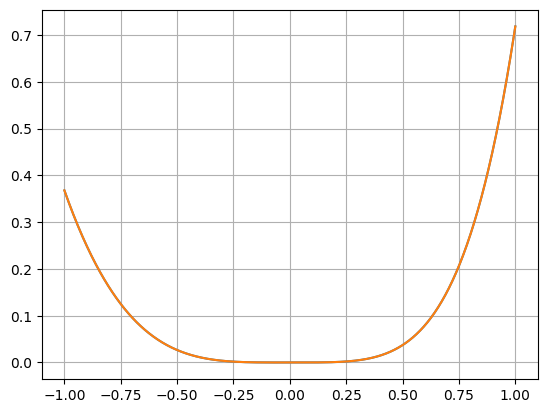

In [29]:
n = 5
x = np.linspace(-1, 1, 1000)
eps = 1e-6

while np.amax(np.abs(Sn(n)(x) - F(x))) >= eps:
    n += 1
print(np.abs(Sn(n)(x) - F(x)))
print(n)

fig, axs = plt.subplots(1, 1)
axs.plot(x, F(x))
axs.plot(x, Sn(n)(x))
axs.grid()


3. Произведем экономизацию степенного ряда до тех пор, пока сохраняется необходимая точность

In [30]:
def T(x, n):
    if n == 0: return 1
    elif n == 1: return x
    else:
        return 2 * x * T(x, n - 1) - T(x, n - 2)
    
T_0 = np.array([1])
T_1 = np.array([0, 1])
def get_T(n):
    T_0 = np.array([1])
    T_1 = np.array([0, 1])
    T = np.empty(0)
    T.append(T_1)
    

Попробуем уменьшить количество слагаемых используя формулы экономизации так, чтобы точность сохранилась:

In [31]:
def eco11(x):
    return 1/1024*(2816*x**9 - 2816*x**7 + 1232*x**5 - 220*x**3 + 11*x + T(x, 11))

def eco10(x):
    return 1/512*(1280*x**8 - 1120*x**6 + 400*x**4 - 50*x**2 + 1 + T(x, 10))
def eco14(x):
    return 1/8192*(29872*x**12 - 39424*x*10 + 26880*x**8 - 9408*x**6 + 1568*x**4 - 98*x**2 + 1 + T(x, 14))
def eco13(x):
    return 1/4096 * (13312*x**11 - 11520*x**9 + 5504*x**7 - 1288*x**5 + 164*x**3 - 9*x + T(x, 13))

def eco12(x):
    return 1/2048*(6144*x**10 - 6912*x**8 + 3584*x**6 - 840*x**4 + 72*x**2 - 1 + T(x, 12))



Заменим $x^{11}$ с помощью полинома Чебышева: $x^{11} = \frac {1} {1024} (2816x^9 - 2816x^7 + 1232x^5 - 220x^3 + 11x + T_{11})$

In [32]:
delta11 = np.amax(np.abs(F(x) - Sn(10)(x) - get_number(11) * eco11(x)))
print(delta11 < eps)
delta10 = np.amax(np.abs(F(x) - Sn(9)(x) - get_number(10) * eco10(x)))
print(delta10 < eps)

True
False


Повторяя аналогично с $x^{10}$, получили, что дальнейший процесс приведет к потере точности 

4. Построим график погрешности каждого этапа экономизации.

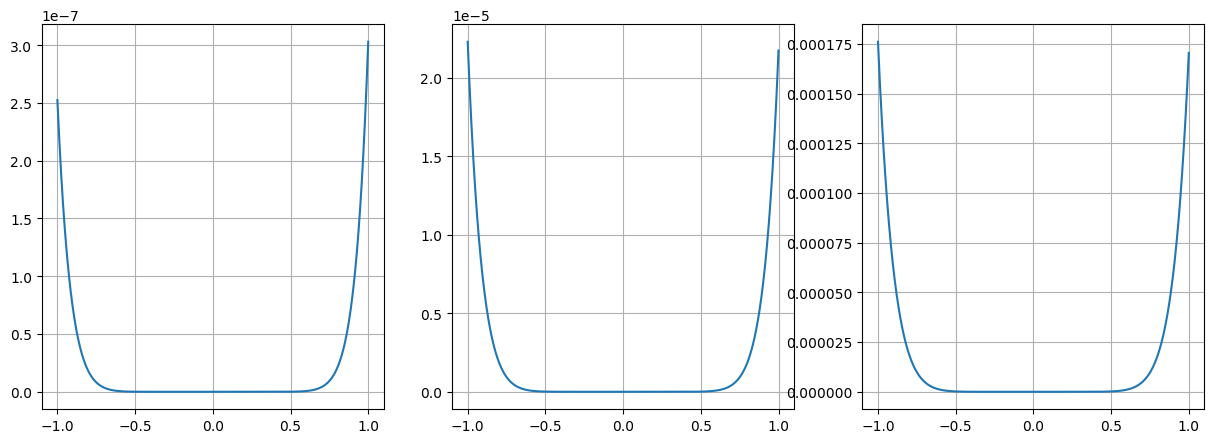

In [33]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
axs[0].plot(x, np.abs(F(x) - Sn(11)(x)))
axs[0].grid()
axs[1].plot(x, np.abs(F(x) - Sn(10)(x) - get_number(10) * eco11(x)))
axs[1].grid()
axs[2].plot(x, np.abs(F(x) - Sn(9)(x) - get_number(9) * eco10(x)))
axs[2].grid()